# CPC353 Assignment 2
#### Name: Tan Chi Feng
#### Matric No: 147515

Firstly, we will import all the libraries and packages needed.

In [1]:
import os
import sys
import numpy as np
import re
import string

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Flatten, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

# Data Preparation
Reading the train.csv, validation.csv and test.csv dataset into data frame with pandas packages.

In [2]:
import pandas as pd

training_data = pd.read_csv("/Volumes/GoogleDrive/My Drive/School of Computer Science/Year 3/Semester 1/4. CPC353 Natural Language Processing/Assignment/Assignment 2/sentiment/train.csv", header=None)
val_data = pd.read_csv("/Volumes/GoogleDrive/My Drive/School of Computer Science/Year 3/Semester 1/4. CPC353 Natural Language Processing/Assignment/Assignment 2/sentiment/validation.csv", header=None)
test_data = pd.read_csv("/Volumes/GoogleDrive/My Drive/School of Computer Science/Year 3/Semester 1/4. CPC353 Natural Language Processing/Assignment/Assignment 2/sentiment/test.csv", header=None)

Renaming the columns of training, validation and test data frame to appropriate column name.

In [3]:
# Rename the columns
training_data.columns = ['Headlines', 'Sentiment']
val_data.columns = ['Headlines', 'Sentiment']
test_data.columns = ['Headlines', 'Sentiment']

Data Cleaning and Preprocessing: Performing stopword removal on all datasets. HTML tags like "<" and ">" will also be removed.

In [4]:
stopwords = [ "a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at", "be", "because", 
             "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do", "does", "doing", "down", "during",
             "each", "few", "for", "from", "further", "had", "has", "have", "having", "he", "he'd", "he'll", "he's", "her", "here", 
             "here's", "hers", "herself", "him", "himself", "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into",
             "is", "it", "it's", "its", "itself", "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or",
             "other", "ought", "our", "ours", "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should", 
             "so", "some", "such", "than", "that", "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's",
             "these", "they", "they'd", "they'll", "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up",
             "very", "was", "we", "we'd", "we'll", "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's",
             "which", "while", "who", "who's", "whom", "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've",
             "your", "yours", "yourself", "yourselves" ]

In [51]:
def remv_stopwords(data):
  data['Headlines'] = data['Headlines'].apply(lambda x : ' '.join([word for word in x.split() if word not in (stopwords)]))
  return data

def remv_htmltags(string):
    result = re.sub('<.*?>','',string)
    return result
    
training_data = remv_stopwords(training_data)
training_data['Headlines']= training_data['Headlines'].apply(lambda cw : remv_htmltags(cw))
training_data['Headlines'] = training_data['Headlines'].str.replace('[{}]'.format(string.punctuation), ' ')

val_data = remv_stopwords(val_data)
val_data['Headlines']= val_data['Headlines'].apply(lambda cw : remv_htmltags(cw))
val_data['Headlines'] = val_data['Headlines'].str.replace('[{}]'.format(string.punctuation), ' ')

test_data = remv_stopwords(test_data)
test_data['Headlines']= test_data['Headlines'].apply(lambda cw : remv_htmltags(cw))
test_data['Headlines'] = test_data['Headlines'].str.replace('[{}]'.format(string.punctuation), ' ')

/var/folders/c_/9cqyc6w948j02tgk3jpzkpvc0000gn/T/ipykernel_4297/423224487.py:11: FutureWarning: The default value of regex will change from True to False in a future version.
  training_data['Headlines'] = training_data['Headlines'].str.replace('[{}]'.format(string.punctuation), ' ')
/var/folders/c_/9cqyc6w948j02tgk3jpzkpvc0000gn/T/ipykernel_4297/423224487.py:15: FutureWarning: The default value of regex will change from True to False in a future version.
  val_data['Headlines'] = val_data['Headlines'].str.replace('[{}]'.format(string.punctuation), ' ')
/var/folders/c_/9cqyc6w948j02tgk3jpzkpvc0000gn/T/ipykernel_4297/423224487.py:19: FutureWarning: The default value of regex will change from True to False in a future version.
  test_data['Headlines'] = test_data['Headlines'].str.replace('[{}]'.format(string.punctuation), ' ')


# Building Dictionary Using Pretrained Word Vectors from GloVe
Building a dictionary named "embeddings_index" by using the pretrained word vectors obtained from https://nlp.stanford.edu/projects/glove/ (specifically the 'glove.6B.300d.txt').

Since it is a dictionary, for instance, if we call embeddings_index['the'], since we supply the key 'the' to the dictionary, the dictionary will return the corresponding word vector that associate with the word 'the'.

In [6]:
with tf.device('/cpu:0'):
    working_dir = "/Volumes/GoogleDrive/My Drive/School of Computer Science/Year 3/Semester 1/4. CPC353 Natural Language Processing/Assignment/Assignment 2"

    embeddings_index = {}

    with open(os.path.join(working_dir, 'glove.6B.300d.txt')) as file:
        for line in file:
            word, coefs = line.split(maxsplit=1)
            coefs = np.fromstring(coefs, 'f', sep=' ')
            embeddings_index[word] = coefs

    print('There are a total of %s word vectors found in glove.6B.300d.txt.' % len(embeddings_index))

2022-01-29 19:09:34.912949: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-01-29 19:09:34.913071: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

There are a total of 400000 word vectors found in glove.6B.300d.txt.


### Testing the dictonary.

In [7]:
embeddings_index['dr']

array([-0.074607 , -0.11633  ,  0.36245  ,  0.36715  , -0.76794  ,
       -0.30341  , -0.18367  ,  0.13902  ,  0.36768  , -1.1403   ,
        0.15194  , -0.58007  , -0.11208  , -0.076548 ,  0.090214 ,
        0.43275  ,  0.024418 ,  0.20571  ,  0.23143  , -0.62702  ,
       -0.32204  ,  0.17888  ,  0.18504  , -0.014398 ,  0.015564 ,
        0.5972   ,  0.070547 , -0.049865 ,  0.13624  , -0.62059  ,
       -0.27566  ,  0.12168  ,  0.075928 ,  0.12725  , -0.19275  ,
        0.23169  ,  0.87206  ,  0.55183  , -0.39115  , -0.54558  ,
       -0.03112  , -0.60598  , -0.046408 ,  0.11338  ,  0.046661 ,
       -0.1819   , -0.28307  , -0.029926 , -0.46608  , -0.39512  ,
       -0.16182  ,  0.38471  , -0.16378  ,  0.25356  ,  0.10304  ,
        1.0363   ,  0.2292   ,  0.43539  ,  0.17291  ,  0.060108 ,
       -0.19593  ,  0.32616  , -0.02618  ,  0.59961  ,  0.42063  ,
       -0.17343  , -0.46433  , -0.010907 , -0.013383 , -0.3362   ,
       -0.1653   , -0.1498   ,  0.16513  ,  0.38764  ,  0.2590

# Tokenizing Text Samples in Training Dataset
We tokenize every row of headlines in the dataset and we assume that each row of headlines has a maximum of 100 words. 

Each unique word will be assigned a unique token, for instance, all the word "increase" will have a token "678". For 

headlines that have less 100 words, the remaining will be assigning a token "0".

In [56]:
MAX_NUM_WORDS = 28000

# Vectorizing the text samples into a 2D integer tensor
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(training_data.Headlines[0:])
sequences = tokenizer.texts_to_sequences(training_data.Headlines[0:])

word_index = tokenizer.word_index
print('There are %s unique tokens in the training dataset.' % len(word_index))

MAX_SEQUENCE_LENGTH = 100

data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH, dtype=object)

labels = to_categorical(training_data.Sentiment - training_data.Sentiment.min())
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

There are 24357 unique tokens in the training dataset.
Shape of data tensor: (61692, 100)
Shape of label tensor: (61692, 3)


For instance, the array “data” consist of all the tokenized words, data[0] which corresponds to the first row of headlines in the training data, will return 100 tokens, since we assume that all headlines will have a maximum of 100 words, empty space will be given token “0”. When we compare it to the first headline training data, we can see that the word “dr” has a token of “384”.

In [57]:
data[0]

array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
       0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
       0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
       0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
       0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
       0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
       0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
       0.0, 382, 102, 228, 1198, 231, 4580, 2959, 2245], dtype=object)

In [10]:
training_data

,Headlines,Sentiment
0,Dr M now interim PM Agong accepts resignation,0
1,MMAG s M Jets targets annual cargo volume grow...,1
2,Civil servants will continue provide quality ...,0
3,KLCI falls 0 76 tracks regional decline,-1
4,Anzo showing signs developing rebound RHB Ret...,0
...,...,...
61687,ace market bound gdb holdings posts record fy1...,1
61688,bina puri titijaya re enter jv develop brickfi...,1
61689,high valuations put red sena spot,1
61690,klci pares gains loses 0 73 global trade war...,-1


# Building Embedding Matrix for Training Dataset
Building an embedding matrix for each tokens in the training dataset by mapping each token to the corresponding word vectors in the "embedding_index" dictionary that we build.

For instance, for the word 'dr', its token number is 384, by looking up to the dictionary, embeddings_index['dr'], a corresponding word vector of 300d will be returned and mapped to token '384'.

In [11]:
EMBEDDING_DIM = 300

print('Preparing embedding matrix.')

# prepare embedding matrix
num_words_train = min(MAX_NUM_WORDS, len(word_index) + 1)
embedding_matrix = np.zeros((num_words_train, EMBEDDING_DIM))
for word, i in word_index.items():
    if i >= MAX_NUM_WORDS:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
print(embedding_matrix.shape)

Preparing embedding matrix.
(24393, 300)


# Generating 3 dimensional inputs for LSTM layers
The two cells below are used to generate 3 dimensional inputs for the LSTM layer of our machine learning model. Since we could not use embedding layer to generate this 3 dimensional inputs, I figure out a way to achieve this using Python.

The 2 for loops in the first cell are to loop through every single token in each row of headlines. For each token, we will look up to the dictionary (embeddings_index) and find its corresponding word vector. Then, we will replace this token with the word vector returned. Note that this operation is viable because I initially set the data type of each token to be an object, instead of float or int, that's why we can assign an array to replace each token directly (this is not possible if the token is of data type int or float).

As a result, the input of our training set, x_train, will have a dimension of (61692, 100, 300), which represents 61692 rows of headlines in the training set, for each row of headline there are 100 tokens, for every token a word vector of 300d is assigned.

In [12]:
for i in range(61692):
    for j in range(100):
        data[i][j] = embedding_matrix[int(data[i][j])]


In [13]:
x_train = np.zeros((61692,100,300))
for j in range(61692):
        x_train[j] = np.stack(data[:][j])

In [14]:
x_train.shape

(61692, 100, 300)

# Tokenizing Text Samples in Validation Dataset

In [15]:
MAX_NUM_WORDS = 3500

# Vectorizing the text samples into a 2D integer tensor
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(val_data.Headlines[0:])
sequences = tokenizer.texts_to_sequences(val_data.Headlines[0:])

word_index = tokenizer.word_index
print('There are %s unique tokens in the validation dataset.' % len(word_index))

MAX_SEQUENCE_LENGTH = 100

valData = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH, dtype=object)

valLabels = to_categorical(val_data.Sentiment - val_data.Sentiment.min())
print('Shape of data tensor:', valData.shape)
print('Shape of label tensor:', valLabels.shape)

There are 2879 unique tokens in the validation dataset.
Shape of data tensor: (1000, 100)
Shape of label tensor: (1000, 3)


# Building Embedding Matrix for Validation Dataset

In [16]:
EMBEDDING_DIM = 300

print('Preparing embedding matrix.')

# prepare embedding matrix
num_words_val = min(MAX_NUM_WORDS, len(word_index) + 1)
embedding_matrix_val = np.zeros((num_words_val, EMBEDDING_DIM))
for word, i in word_index.items():
    if i >= MAX_NUM_WORDS:
        continue
    embedding_vector_val = embeddings_index.get(word)
    if embedding_vector_val is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix_val[i] = embedding_vector_val
print(embedding_matrix_val.shape)

Preparing embedding matrix.
(2880, 300)


# Generating 3 dimensional inputs for LSTM layers

In [17]:
for i in range(1000):
    for j in range(100):
        valData[i][j] = embedding_matrix_val[int(valData[i][j])]

In [18]:
x_val = np.zeros((1000,100,300))
for j in range(1000):
        x_val[j] = np.stack(valData[:][j])

# Tokenizing Text Samples in Test Dataset

In [19]:
MAX_NUM_WORDS = 3500

# Vectorizing the text samples into a 2D integer tensor
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(test_data.Headlines[0:])
sequences = tokenizer.texts_to_sequences(test_data.Headlines[0:])

word_index = tokenizer.word_index
print('There are %s unique tokens in the testing dataset.' % len(word_index))

MAX_SEQUENCE_LENGTH = 100

testData = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH, dtype=object)

testLabels = to_categorical(test_data.Sentiment - test_data.Sentiment.min())
print('Shape of data tensor:', testData.shape)
print('Shape of label tensor:', testLabels.shape)

There are 3055 unique tokens in the testing dataset.
Shape of data tensor: (1000, 100)
Shape of label tensor: (1000, 3)


# Building Embedding Matrix for Test Dataset

In [20]:
EMBEDDING_DIM = 300

print('Preparing embedding matrix.')

# prepare embedding matrix
num_word_test = min(MAX_NUM_WORDS, len(word_index) + 1)
embedding_matrix_test = np.zeros((num_word_test, EMBEDDING_DIM))
for word, i in word_index.items():
    if i >= MAX_NUM_WORDS:
        continue
    embedding_vector_test = embeddings_index.get(word)
    if embedding_vector_test is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix_test[i] = embedding_vector_test
print(embedding_matrix_test.shape)

Preparing embedding matrix.
(3056, 300)


# Generating 3 dimensional inputs for LSTM layers

In [21]:
for i in range(1000):
    for j in range(100):
        testData[i][j] = embedding_matrix_test[int(testData[i][j])]

In [22]:
x_test = np.zeros((1000,100,300))
for j in range(1000):
        x_test[j] = np.stack(testData[:][j])

# Finalized data preparation and checking of all the x (input) and y(labels) of training, validation and test sets.

In [23]:
x_train.shape
x_val.shape
x_test.shape

(1000, 100, 300)

In [24]:
y_train = labels
y_val = valLabels
y_test = testLabels

In [25]:
y_train.shape

(61692, 3)

# Model Building

Create a sequential model to prepare a plain stack of layers where each layer has exactly one input tensor and one output tensor.

In [26]:
model = Sequential()

Adding Bidirectional LSTM with 128 memory units as the first layer, following by a flatten layer (this is required when the return_sequences are set to true,  where the lstm model will return the hidden state output for each input time step), a Dense Layer with 128 neurons and last but not least a Dense Layer with 'softmax' activation function applied and it is set to output 3 types of label (since our sentiment label consist of 'negative', 'neutral' and 'positive'.

Other than the final Dense Layer, all other LSTM and Dense layers are using 'relu' activation function.

Dropout layers with rate of 0.2 are applied after the first Bidiretional LSTM layer and the second Dense layer to prevent the model from overfitting the training data.

In [27]:
model.add(Bidirectional(LSTM(128, input_shape=(x_train.shape[1:]), activation='relu', return_sequences=True)))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(len(y_train[0]), activation='softmax'))

Compiling the model with Adam optimzizer and loss functiom of categorical_crossentropy.

In [28]:
opt1 = SGD(learning_rate=0.01, momentum=0.9)
opt2 = Adam(learning_rate=1e-3, decay=1e-5)

In [29]:
# compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=opt2,
              metrics=['accuracy'])

Fitting the training data into the model to train the model with batch size of 1024 and 5 epochs. 

In [30]:
with tf.device('/cpu:0'):
    training_model = model.fit(x_train, y_train,
                                batch_size=1024,
                                epochs=5, 
                                validation_data = (x_val, y_val))

2022-01-29 19:10:02.107905: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/5


2022-01-29 19:10:02.622568: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


61/61 [==============================] - ETA: 0s - loss: 0.9323 - accuracy: 0.5475

2022-01-29 19:10:50.181109: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


61/61 [==============================] - 48s 776ms/step - loss: 0.9323 - accuracy: 0.5475 - val_loss: 0.8261 - val_accuracy: 0.5940
Epoch 2/5
61/61 [==============================] - 48s 784ms/step - loss: 372.9150 - accuracy: 0.6562 - val_loss: 0.8799 - val_accuracy: 0.5620
Epoch 3/5
61/61 [==============================] - 50s 818ms/step - loss: 0.7359 - accuracy: 0.6838 - val_loss: 0.9085 - val_accuracy: 0.5590
Epoch 4/5
61/61 [==============================] - 48s 788ms/step - loss: 0.6969 - accuracy: 0.7046 - val_loss: 0.9570 - val_accuracy: 0.5350
Epoch 5/5
61/61 [==============================] - 48s 788ms/step - loss: 0.6651 - accuracy: 0.7206 - val_loss: 0.8663 - val_accuracy: 0.5900


# Model Evaluation

Plotting a line graph to see how training and validation accuracy increase after each epochs.

Text(0.5, 1.0, 'Training Accuracy vs Validation Accuracy')

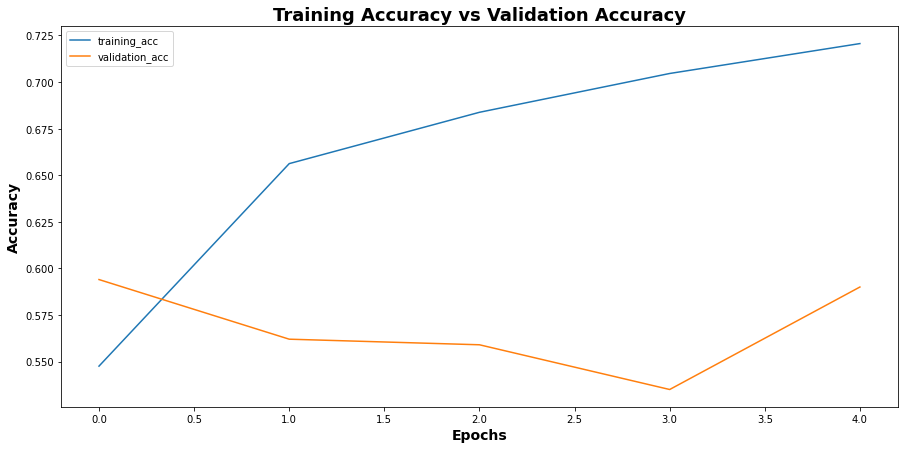

In [48]:
#plot accuracy
plt.figure(figsize=(15, 7))
plt.plot(range(5), training_model.history['accuracy'])
plt.plot(range(5), training_model.history['val_accuracy'])
plt.legend(['training_acc', 'validation_acc'])
plt.xlabel("Epochs", fontweight="bold", fontsize="14")
plt.ylabel("Accuracy", fontweight="bold", fontsize="14")
plt.title('Training Accuracy vs Validation Accuracy', fontweight="bold", fontsize="18")

Evaluate the model with test dataset and display the corresponding accuracy and loss.

In [49]:
with tf.device('/cpu:0'):
    loss, accuracy = model.evaluate(x_test, y_test, verbose=0)

    print('Accuracy (Test Set): %f' % (accuracy))
    print('Loss     (Test Set): %f' % (loss))

Accuracy (Test Set): 0.615000
Loss     (Test Set): 0.845002


In [34]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 100, 256)         439296    
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 100, 256)          0         
                                                                 
 flatten (Flatten)           (None, 25600)             0         
                                                                 
 dense (Dense)               (None, 128)               3276928   
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 3)                 387       
                                                        

# Model Testing

In [53]:
with tf.device('/cpu:0'):
    output = model.predict(x_test)

print(output.shape)

(1000, 3)


In [54]:
output

array([[0.13466485, 0.20781979, 0.65751535],
       [0.009301  , 0.7471878 , 0.24351121],
       [0.02135628, 0.8545073 , 0.12413646],
       ...,
       [0.5479214 , 0.0211898 , 0.43088883],
       [0.6611812 , 0.26026696, 0.07855193],
       [0.01668142, 0.09117854, 0.89214003]], dtype=float32)

In [37]:
result = np.argmax(output, axis=1)
print(result)

[2 1 1 0 1 1 2 2 2 0 1 1 1 2 0 0 2 0 0 1 1 0 0 2 2 2 0 1 1 0 1 1 2 1 0 1 2
 2 1 1 1 1 0 0 0 0 1 1 0 2 1 1 2 1 0 1 0 1 1 2 2 0 0 0 2 1 1 2 2 1 1 2 1 1
 2 2 1 1 2 1 1 2 2 1 2 1 2 2 1 1 1 2 2 2 2 2 1 2 0 1 1 2 1 2 2 1 2 1 1 2 0
 1 1 0 0 2 2 1 0 2 1 1 2 1 0 0 2 2 1 2 0 2 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 2
 1 0 0 2 2 2 2 1 2 2 1 2 1 1 0 2 0 2 1 1 1 2 2 1 1 0 2 2 1 2 1 1 2 1 2 2 2
 2 2 2 2 2 2 2 2 0 2 1 1 2 2 0 2 0 2 2 2 2 1 1 2 2 0 2 0 2 2 0 1 1 0 1 2 2
 1 2 2 2 1 1 1 2 0 0 2 0 1 0 1 1 2 0 2 2 2 1 2 0 1 2 0 1 1 1 2 1 0 2 2 1 1
 2 1 0 2 1 0 1 2 1 2 1 0 1 2 2 2 1 2 1 1 0 0 1 2 0 1 1 2 2 1 0 1 1 2 2 2 0
 2 2 0 1 1 2 2 2 2 2 2 1 0 1 1 1 2 1 1 2 2 2 1 0 1 2 1 2 2 0 2 1 1 1 0 2 1
 1 0 0 2 0 1 1 1 1 2 2 0 2 0 2 0 2 2 1 0 2 0 2 1 1 1 1 2 2 1 1 1 1 0 1 0 2
 2 0 0 2 0 0 2 0 1 2 1 1 1 2 1 2 2 1 1 0 2 2 0 2 1 1 2 0 2 1 1 1 2 1 2 2 0
 1 2 2 0 1 1 2 2 1 2 0 2 1 0 0 0 0 1 1 2 2 2 0 2 1 1 0 1 2 1 0 2 0 1 1 2 2
 0 2 2 0 2 2 1 2 0 2 1 1 2 1 2 2 0 1 2 0 2 1 1 2 0 1 0 0 2 2 2 2 2 2 1 2 1
 0 2 1 2 0 1 2 1 0 1 1 2 

In [38]:
sentiment_test = []
for i in range(len(result)):
    if result[i] == 0:
        sentiment_test.append("negative")
    elif result[i] == 1:
        sentiment_test.append("neutral")
    else:
        sentiment_test.append("positive")

In [50]:
sentiment_test

['positive',
 'neutral',
 'neutral',
 'negative',
 'neutral',
 'neutral',
 'positive',
 'positive',
 'positive',
 'negative',
 'neutral',
 'neutral',
 'neutral',
 'positive',
 'negative',
 'negative',
 'positive',
 'negative',
 'negative',
 'neutral',
 'neutral',
 'negative',
 'negative',
 'positive',
 'positive',
 'positive',
 'negative',
 'neutral',
 'neutral',
 'negative',
 'neutral',
 'neutral',
 'positive',
 'neutral',
 'negative',
 'neutral',
 'positive',
 'positive',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'negative',
 'negative',
 'negative',
 'negative',
 'neutral',
 'neutral',
 'negative',
 'positive',
 'neutral',
 'neutral',
 'positive',
 'neutral',
 'negative',
 'neutral',
 'negative',
 'neutral',
 'neutral',
 'positive',
 'positive',
 'negative',
 'negative',
 'negative',
 'positive',
 'neutral',
 'neutral',
 'positive',
 'positive',
 'neutral',
 'neutral',
 'positive',
 'neutral',
 'neutral',
 'positive',
 'positive',
 'neutral',
 'neutral',
 'positive',
 'neutra

# Conclusion
This Bidirectional LSTM classifier is capable of performing sentiment analysis with an acceptable accuracy based on the dataset that we tested on. We can further improve the accuracy by training the model with more accurate training sets by having experts to annotate the headlines. Ultimately, the quality of the training sets plays a very important role in determining the accuracy of the model.